# Simple Benchmark - How to compare multiple models?

This tutorial shows how to create a simple benchmark with different models on different datasets. Furthert, it investigates on the individual performance of the NeuralProphet models on the different datasets.

#### Imports

In [25]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

In [26]:
import os
import pandas as pd
import numpy as np

from tot.dataset import Dataset
from tot.models import LinearRegressionModel, NeuralProphetModel, ProphetModel, \
    TorchProphetModel, SeasonalNaiveModel, NaiveModel
from tot.benchmark import SimpleBenchmark
from tot.metrics import ERROR_FUNCTIONS

from neuralprophet import set_random_seed, set_log_level
from neuralprophet.df_utils import prep_or_copy_df

from plotly_resampler import register_plotly_resampler, unregister_plotly_resampler

In [27]:
set_log_level("ERROR")

#### Plot settings
We use ``plotly`` for standard plotting and activate the ploltly-resampler package to seamlessly display plots with large data.

In [69]:
pd.options.plotting.backend = 'matplotlib'
register_plotly_resampler('auto')

## 1. Manage data
##### Load datasets
We load the 3 datasets that we will use in the benchmark, which is the **AirPassenger** dataset, the **SFLoad** dataset and the **Energy** dataset.

In [29]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_air_passengers = pd.read_csv(data_location + "air_passengers.csv")
df_sf_load= pd.read_csv(data_location + "energy/SF_hospital_load.csv")
df_energy= pd.read_csv(data_location + "../kaggle-energy/datasets/tutorial01-full.csv")

##### Inspect dataset

First, let´s have a closer look at the datasets. As we can see, the **AirPassenger** dataset has monthly ('MS') data, it has a yearly seasonality, which grows with multiplicative scale, and has an increasing trend.  

data samples: 8760


<AxesSubplot: xlabel='ds'>

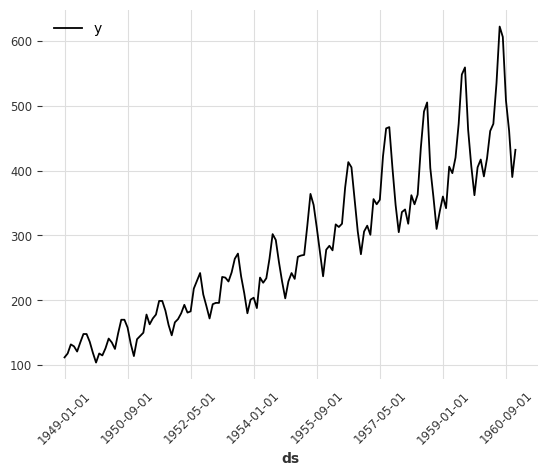

In [70]:
print('data samples:', df_sf_load.shape[0])
df_air_passengers.plot(x='ds', y='y')

The **SFLoad** dataset has hourly frequency, a daily and weekly seasonality. It does not seem to have a clear trend. 

data samples: 8760


<AxesSubplot: xlabel='ds'>

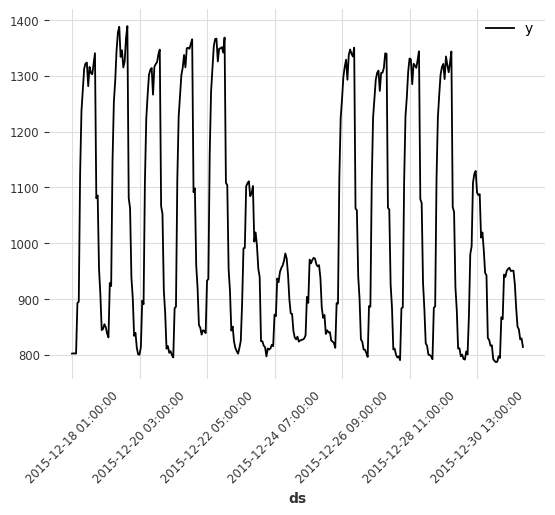

In [74]:
print('data samples:', df_sf_load.shape[0])
df_sf_load.plot(x= 'ds', y='y')

The **Energy** dataset has hourly frequency, a daily seasonality. It does not seem to have a clear trend and has more spikes than the SFLoad dataset.

data samples: 35064


<AxesSubplot: xlabel='ds'>

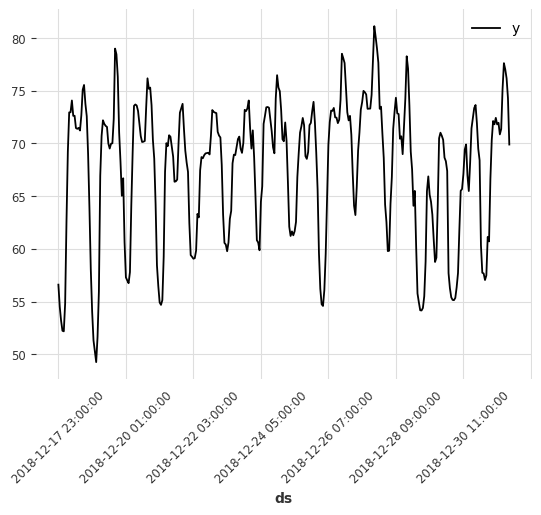

In [73]:
print('data samples:', df_energy.shape[0])
df_energy.plot(x= 'ds', y='y')

## 2. Set up simple benchmark 1 with the AirPassenger dataset and 6 different models
We offer a template for a simple benchmark that is filled with the selected dataset(s), model(s) and model parameters.

First, we select the AirPassenger dataset. Therefore, we input the ``air_passengers_df``, the name, and the data's frequency.
Ideally, we add all available information about the dataset, in this case as well the monthly frequency ``freq="MS"``.

In [33]:
dataset_list = [
    Dataset(df=df_air_passengers, name="air_passengers", freq="MS"),
]

##### Configure common model hyperparameters
We want to compare the selected models on the same prediction task. We define N_FORECAST = 3 for all models. Besides
Prophet and TorchProphet only offers 1-step predictions. For
NeuralProphet and Prophet, we commonly set ``"yearly_seasonality": True`` and ``"seasonality_mode": "multiplicative"``. For all NeuralProphet models (which includes TorchProphet) we set a common ``learning_rate`` and ``epochs``.

In [34]:
N_FORECASTS = 3
SEASONALITY_MODE = 'multiplicative'
LR = 0.01
EPOCHS = 50

##### Select models and individual model parameters
In total, we compare 6 different models. For each model we define the relevant hyperparameters. The NeuralProphet model
we compare among 3 different configurations. The most simple configuration of NeuralProphet has **no autoregression** enabled.
The 2nd configuration has **autoregression** enabled. For the 3rd configuration we add a pre-defined number of **hidden layers**. For the Prophet model we implement the origional version as well as the offered neuralprophet wrapper, i.e. TorchProphet.

In [35]:
model_classes_and_params = [
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 9,  "seasonality_mode": SEASONALITY_MODE,
                          "yearly_seasonality": True, "num_hidden_layers": 1, "d_hidden": 64,
                          "learning_rate": LR, "epochs": EPOCHS }),
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 9,  "seasonality_mode": SEASONALITY_MODE,
                          "yearly_seasonality": True,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (NeuralProphetModel, {"n_forecasts": 1, "seasonality_mode": SEASONALITY_MODE,
                          "yearly_seasonality": True,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (ProphetModel, {"seasonality_mode": "multiplicative"}),
    (TorchProphetModel, {"seasonality_mode": "multiplicative", 'interval_width': 0,
                        "learning_rate": LR, "epochs": EPOCHS}),
    (SeasonalNaiveModel, {"n_forecasts": N_FORECASTS, "season_length": 12}),
    (NaiveModel, {"n_forecasts": N_FORECASTS}),
    (LinearRegressionModel, {"n_forecasts": N_FORECASTS, "lags": 9, "output_chunk_length": 3}),
]

#### Configure the benchmark
Now, we add the dataset and the configured models, and instantiate a benchmark. We select to return the MAPE error metric.
Further error metrics can be added on demand. Further, we select he test data to be 40%.

In [36]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params,
    datasets=dataset_list,
    metrics=["MAPE"],
    test_percentage=40,
)

Besides the SimpleBenchmark class we have further templates for pre-configured benchmarks as well as the option to manually
configure a benchmark. We further offer various eror metrics.

#### Run the benchmark
We simply execute the benchmark by calling benchmark.run() and print the train and test results. To ensure comparability a seed is set within the procedure.

In [37]:
results_train, results_test = benchmark.run()

08:30:12 - cmdstanpy - INFO - Chain [1] start processing
08:30:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

In [38]:
results_test

,data,model,params,experiment,MAPE
0,air_passengers,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 9, 'seasonality_m...",air_passengers_NeuralProphet_n_forecasts_3_n_l...,5.573031
1,air_passengers,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 9, 'seasonality_m...",air_passengers_NeuralProphet_n_forecasts_3_n_l...,11.238141
2,air_passengers,NeuralProphet,"{'n_forecasts': 1, 'seasonality_mode': 'multip...",air_passengers_NeuralProphet_n_forecasts_1_sea...,8.911716
3,air_passengers,Prophet,"{'seasonality_mode': 'multiplicative', '_data_...",air_passengers_Prophet_seasonality_mode_multip...,5.045631
4,air_passengers,TorchProphet,"{'seasonality_mode': 'multiplicative', 'interv...",air_passengers_TorchProphet_seasonality_mode_m...,6.986667
5,air_passengers,SeasonalNaive,"{'n_forecasts': 3, 'season_length': 12, '_data...",air_passengers_SeasonalNaive_n_forecasts_3_sea...,9.339753
6,air_passengers,NaiveModel,"{'n_forecasts': 3, '_data_params': {'freq': 'M...",air_passengers_NaiveModel_n_forecasts_3__data_...,14.818103
7,air_passengers,LinearRegressionModel,"{'n_forecasts': 3, 'lags': 9, 'output_chunk_le...",air_passengers_LinearRegressionModel_n_forecas...,8.316120


## Let`s have a look at the individual results
First, we need to manually split the train and test data. Therefore, we use 2 helper functions. Since the test df appends n_lags, we generate 2 different sets of df, one is for ``n_lags=0`` and the other one for ``n_lags=9``.


In [39]:
def _split_df(df, n_lags, test_percentage):
    """Splits timeseries df into train and validation sets.
    Additionally, prevents overbleed of targets. Overbleed of inputs can be configured.
    In case of global modeling the split could be either local or global.

    Parameters
    ----------
        df : pd.DataFrame
            data to be splitted
        n_lags : int
            identical to model
        test_percentage : float, int
            fraction (0,1) of data to use for holdout validation set, or number of validation samples >1

    Returns
    -------
        pd.DataFrame
            training data
        pd.DataFrame
            validation data
    """
    # Receives df with single ID column
    assert len(df["ID"].unique()) == 1
    n_samples = len(df)
    if 0.0 < test_percentage < 1.0:
        n_valid = max(1, int(n_samples * test_percentage))
    else:
        assert test_percentage >= 1
        assert type(test_percentage) == int
        n_valid = test_percentage
    n_train = n_samples - n_valid
    assert n_train >= 1

    split_idx_train = n_train
    split_idx_val = split_idx_train+1 if n_lags==0 else split_idx_train-(n_lags+1)+1
    df_train = df.copy(deep=True).iloc[:split_idx_train].reset_index(drop=True)
    df_val = df.copy(deep=True).iloc[split_idx_val:].reset_index(drop=True)
    return df_train, df_val

In [40]:
def split_df(df, n_lags, test_percentage=0.25, local_split=False):
    """Splits timeseries df into train and validation sets.

    Prevents overbleed of targets. Overbleed of inputs can be configured.
    In case of global modeling the split could be either local or global.

    Parameters
    ----------
        df : pd.DataFrame
            dataframe containing column ``ds``, ``y``, and optionally``ID`` with all data
        n_lags : int
            identical to NeuralProphet
        test_percentage : float, int
            fraction (0,1) of data to use for holdout validation set, or number of validation samples >1
        local_split : bool
            when set to true, each episode from a  dataframes will be split locally

    Returns
    -------
        pd.DataFrame
            training data
        pd.DataFrame
            validation data
    """
    df, _, _, _ = prep_or_copy_df(df)
    df_train = pd.DataFrame()
    df_val = pd.DataFrame()
    if local_split:
        for df_name, df_i in df.groupby("ID"):
            df_t, df_v = _split_df(df_i, n_lags, test_percentage)
            df_train = pd.concat((df_train, df_t.copy(deep=True)), ignore_index=True)
            df_val = pd.concat((df_val, df_v.copy(deep=True)), ignore_index=True)
    else:
        if len(df["ID"].unique()) == 1:
            for df_name, df_i in df.groupby("ID"):
                df_train, df_val = _split_df(df_i, n_lags, test_percentage)

    # df_train and df_val are returned as pd.DataFrames
    return df_train, df_val

In [41]:
df_train_air, df_test_air = split_df(df=df_air_passengers, n_lags=9, test_percentage=0.40, local_split=False)
df_train_air_1step, df_test_air_1step = split_df(df=df_air_passengers, n_lags=0, test_percentage=0.40, local_split=False)

#### NeuralProphet configuration 1

We instantiate the NeuralProphet configuration with the same hyperparameters as for the benchmark. To ensure comparability, it is important to set a seed.

In [42]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=1,
    seasonality_mode=SEASONALITY_MODE,
    yearly_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
)

We fit and predict the individual model.

In [43]:
metrics_train = m.fit(df=df_train_air_1step, freq="MS", minimal=True)
forecast = m.predict(df=df_test_air_1step)

We calculate the MAPE of our test data and compare it with the overall results above.

In [44]:
def calc_MAPE(predictions, truth):
    metric_test_list = []
    predictions = predictions.fillna(value=np.nan)
    n_yhats_test = sum(["yhat" in colname for colname in predictions.columns])
    for x in range(1, n_yhats_test + 1):
        metric_test_list.append(
            ERROR_FUNCTIONS['MAPE'](
                predictions=predictions["yhat{}".format(x)].values,
                truth=truth.iloc[:, 1].values,
            )
        )   
    MAPE = np.nanmean(metric_test_list, dtype="float32")
    return MAPE, metric_test_list

In [45]:
MAPE, test_metrics_list = calc_MAPE(forecast, df_test_air_1step)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)

MAPE for each forecast step [8.967839181423187]
MAPE 8.967839


Let's print the results, to have a closer look. We highlight the 1 step ahead forecast, since NeuralProphet without autoregression only creates 1 step ahead forecasts.

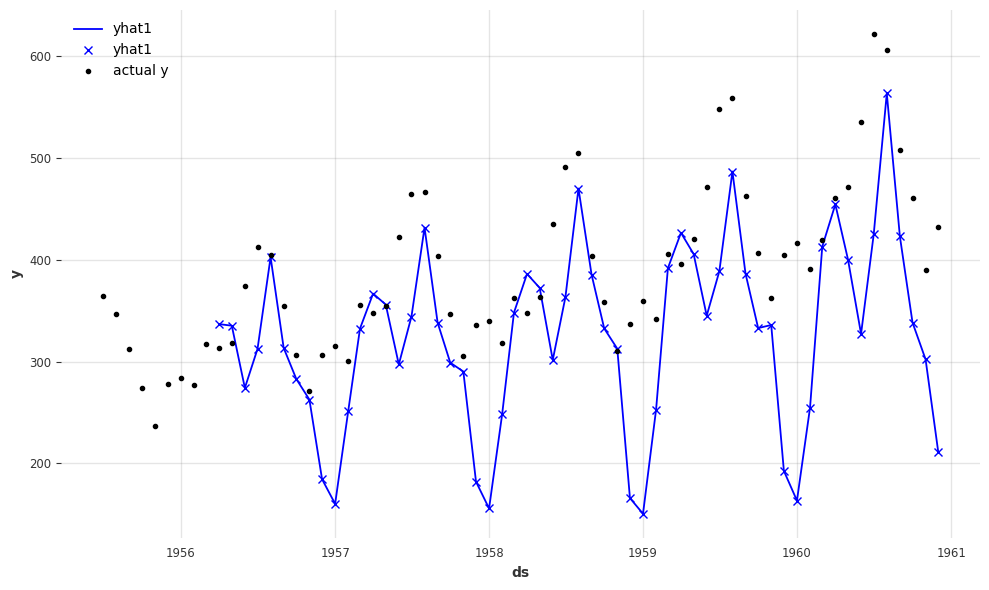

In [84]:
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=1)

Let's  investigate the results of the other model configurations.
#### NeuralProphet configuration 2

MAPE for each forecast step [20.00395804643631, 17.417235672473907, 21.310852468013763]
MAPE 19.577349


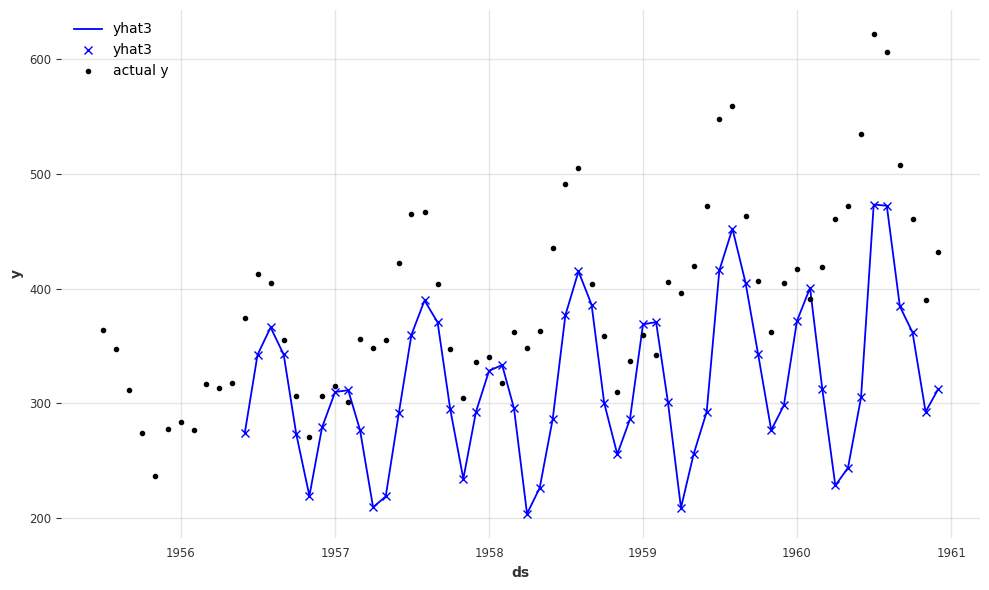

In [85]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags= 9,
    seasonality_mode=SEASONALITY_MODE,
    yearly_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train = m.fit(df=df_train_air, freq="MS", minimal=True)
forecast = m.predict(df=df_test_air)
MAPE, test_metrics_list = calc_MAPE(forecast, df_test_air)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
# m.plot(forecast, plotting_backend='plotly', forecast_in_focus=N_FORECASTS)
fig =m.plot(forecast, plotting_backend='matplotlib', forecast_in_focus=N_FORECASTS)


#### NeuralProphet configuration 3

MAPE for each forecast step [16.18771106004715, 8.443690091371536, 7.3170192539691925]
MAPE 10.649474


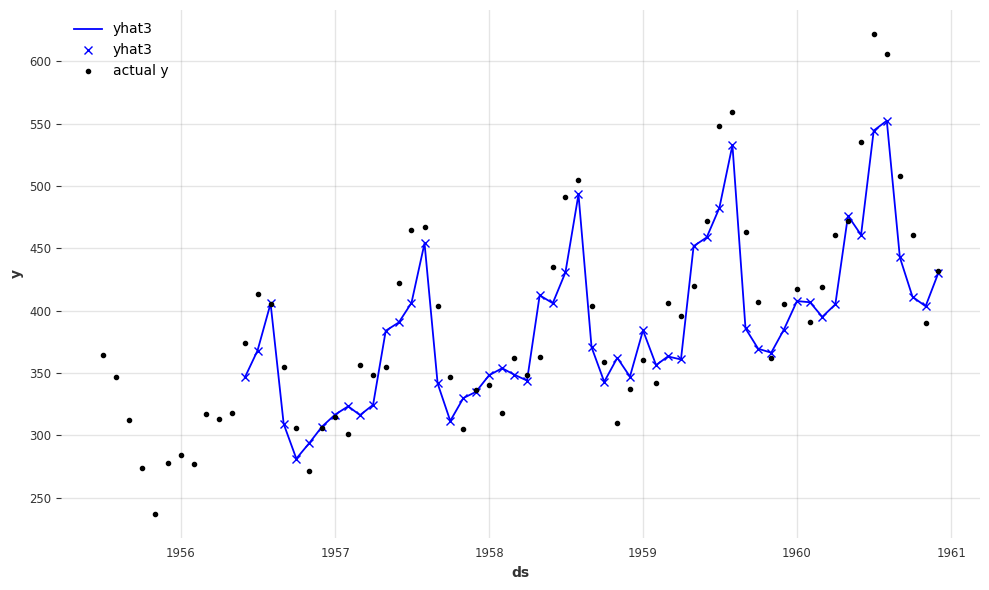

In [86]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags=9,
    seasonality_mode=SEASONALITY_MODE,
    yearly_seasonality=True,
    num_hidden_layers=1,
    d_hidden=64,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train = m.fit(df=df_train_air, freq="MS", minimal=True)
forecast = m.predict(df=df_test_air)
MAPE, test_metrics_list = calc_MAPE(forecast, df_test_air)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=N_FORECASTS)

#### TorchProphet

MAPE for each forecast step [15.198065340518951]
MAPE 15.198066


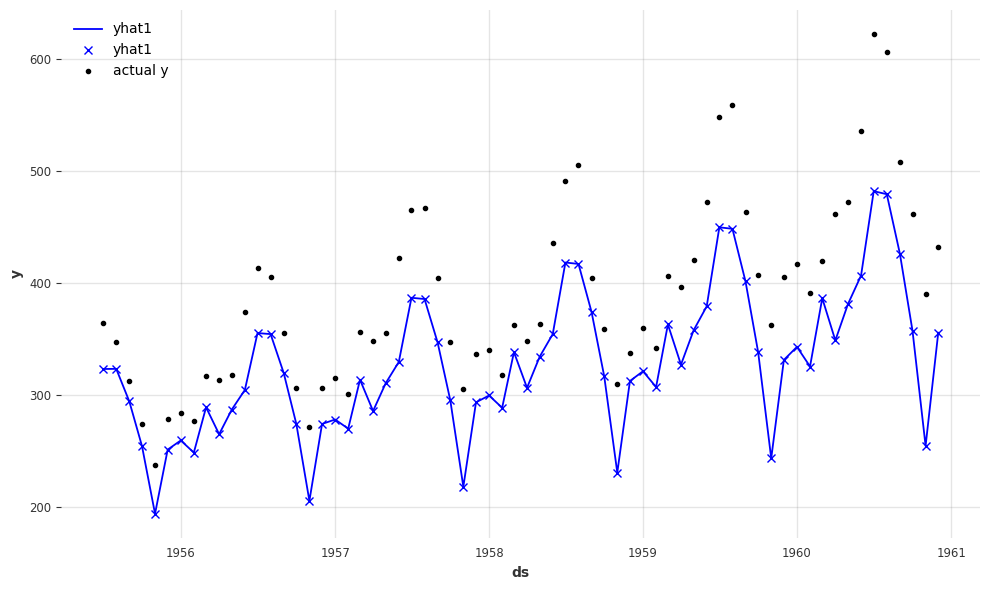

In [87]:
set_random_seed(42)
m = TorchProphetModel.model_class(
    seasonality_mode=SEASONALITY_MODE,
    interval_width=0,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train = m.fit(df=df_train_air, freq="MS", minimal=True)
forecast = m.predict(df=df_test_air)
MAPE, test_metrics_list = calc_MAPE(forecast, df_test_air)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=1)

**Result discussion:** Comparing all models, the **Prophet model** achieves the best results on the AirPassenger data. This can be reasoned by the clear seasonality and trend in combination with little noise in the data. Hence, autoregression is not necessary to predict future data. 

A similar result is achieved by the **TorchProphet model**, which has the same capability as the Prophet model although is initialized differently. Regarding the NeuralProphet configurations the configuration 3 perfoms best. Its performance is  close to the Prophet model, however, entails a more complex configuration.

## 3. Set up simple benchmark 2 with SF Load data and the same 6  models

##### Configure and run the benchmark

We select the dataset, select and configure the models, and set up the benchmark by using the SimpleBenchmark template the same way as before. 

In [50]:
dataset_list = [
    Dataset(df=df_sf_load, name="sf_load", freq="H"),
]

In [51]:
N_FORECASTS = 3
LR = 0.01
EPOCHS = 20

In [52]:
model_classes_and_params = [
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 24,
                          "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False, 
                          "num_hidden_layers": 1, "d_hidden": 64,
                          "n_changepoints":0, "growth":'linear',
                          "learning_rate": LR, "epochs": EPOCHS }),
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 24,
                          "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False, 
                           "n_changepoints":0, "growth":'linear',
                          "learning_rate": LR, "epochs": EPOCHS}),
    (NeuralProphetModel, {"n_forecasts": 1,
                          "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False, 
                          "n_changepoints":0, "growth":'linear',
                          "learning_rate": LR, "epochs": EPOCHS}),
    (ProphetModel, {"daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False }),
    (TorchProphetModel, {'interval_width': 0, 
                         "daily_seasonality": True, "weekly_seasonality": True, "yearly_seasonality": False}),
    (SeasonalNaiveModel, {"n_forecasts": N_FORECASTS, "season_length": 24}),
    (NaiveModel, {"n_forecasts": N_FORECASTS}),
    (LinearRegressionModel, {"n_forecasts": N_FORECASTS, "lags": 24, "output_chunk_length": 3}),
]

In [53]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params,
    datasets=dataset_list,
    metrics=["MAPE"],
    test_percentage=40,
)

We run the benchmark by calling benchmark.run() and print the train and test results.

In [54]:
results_train, results_test = benchmark.run()
results_test

08:31:06 - cmdstanpy - INFO - Chain [1] start processing
08:31:06 - cmdstanpy - INFO - Chain [1] done processing


Finding best initial lr:   0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/5230 [00:00<?, ?it/s]

  0%|          | 0/3478 [00:00<?, ?it/s]

,data,model,params,experiment,MAPE
0,sf_load,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 24, 'daily_season...",sf_load_NeuralProphet_n_forecasts_3_n_lags_24_...,2.326252
1,sf_load,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 24, 'daily_season...",sf_load_NeuralProphet_n_forecasts_3_n_lags_24_...,3.945043
2,sf_load,NeuralProphet,"{'n_forecasts': 1, 'daily_seasonality': True, ...",sf_load_NeuralProphet_n_forecasts_1_daily_seas...,7.201104
3,sf_load,Prophet,"{'daily_seasonality': True, 'weekly_seasonalit...",sf_load_Prophet_daily_seasonality_True_weekly_...,7.358816
4,sf_load,TorchProphet,"{'interval_width': 0, 'daily_seasonality': Tru...",sf_load_TorchProphet_interval_width_0_daily_se...,7.647678
5,sf_load,SeasonalNaive,"{'n_forecasts': 3, 'season_length': 24, '_data...",sf_load_SeasonalNaive_n_forecasts_3_season_len...,7.058735
6,sf_load,NaiveModel,"{'n_forecasts': 3, '_data_params': {'freq': 'H'}}",sf_load_NaiveModel_n_forecasts_3__data_params_...,7.079551
7,sf_load,LinearRegressionModel,"{'n_forecasts': 3, 'lags': 24, 'output_chunk_l...",sf_load_LinearRegressionModel_n_forecasts_3_la...,3.701770


## Let`s have a look at the individual results
First, we manually split the train and test data again.


In [55]:
df_train_sf_load, df_test_sf_load = split_df(df=df_sf_load, n_lags=24, test_percentage=0.40, local_split=False)
df_train_sf_load_1step, df_test_sf_load_1step = split_df(df=df_sf_load, n_lags=0, test_percentage=0.40, local_split=False)

#### NeuralProphet Configuration 1

We instantiate the NeuralProphet configuration 1 with the same hyperparameters as in the benchmark. We set the seasonalities. Since the SFLoad data has no clear trend, we set ``n_changpoints=0`` and ``growth='linear'`` to predict one linear trend over the full train data range.

MAPE for each forecast step [7.201926410198212]
MAPE 7.201926


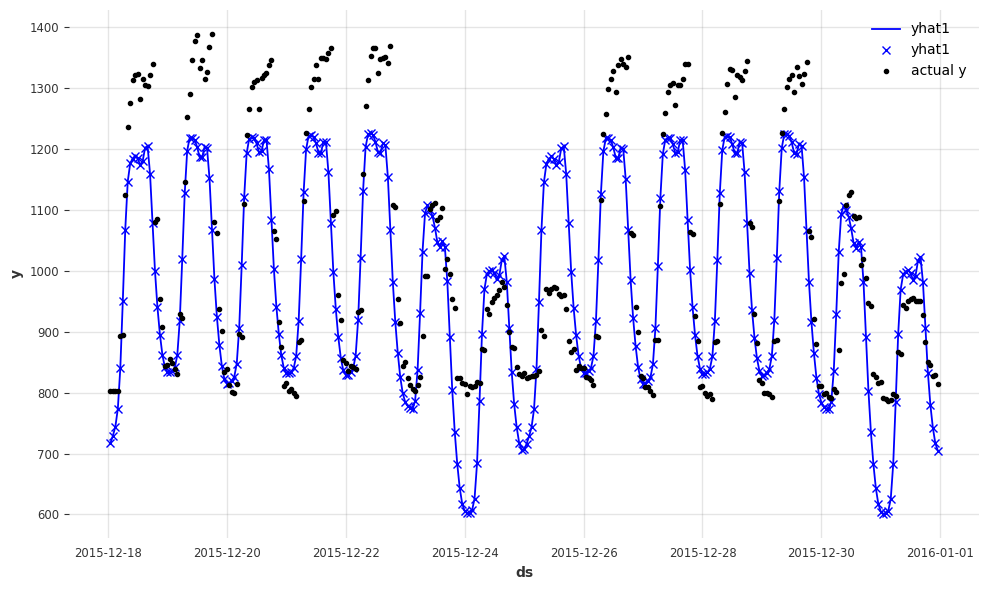

In [88]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=1,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    learning_rate=LR,
    epochs=EPOCHS,
    n_changepoints=0,
    growth='linear',
)
metrics_train = m.fit(df=df_train_sf_load_1step, freq="H", minimal=True)
forecast = m.predict(df=df_test_sf_load_1step)
MAPE, test_metrics_list = calc_MAPE(forecast, df_test_sf_load_1step)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)

m.plot(forecast, plotting_backend='plotly', forecast_in_focus=1)

#### NeuralProphet Configuration 2
We add autoregression with ``n_lags=24`` which equal 24h.

Finding best initial lr:   0%|          | 0/243 [00:00<?, ?it/s]

MAPE for each forecast step [3.0964724719524384, 3.293802961707115, 3.9857346564531326]
MAPE 3.45867


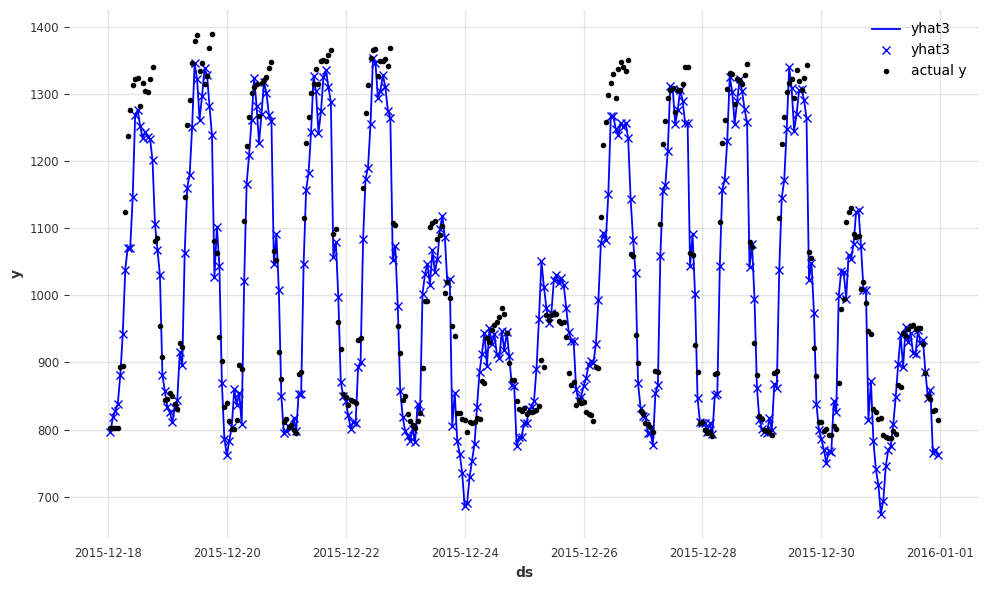

In [89]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    n_lags=24,
    epochs=EPOCHS,
    n_changepoints=0, 
    growth='linear',
)
metrics_train = m.fit(df=df_train_sf_load, freq="H",  minimal=True)
forecast = m.predict(df=df_test_sf_load)
MAPE, test_metrics_list = calc_MAPE(forecast, df_test_sf_load)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)

m.plot(forecast, plotting_backend='plotly', forecast_in_focus=N_FORECASTS)

#### NeuralProphet Configuration 3
We add one hidden layer ``num_hidden_layers=1`` to the model with ``d_hidden=64``.

Finding best initial lr:   0%|          | 0/243 [00:00<?, ?it/s]

MAPE for each forecast step [1.885266974568367, 2.022111974656582, 2.47490331530571]
MAPE 2.1274273


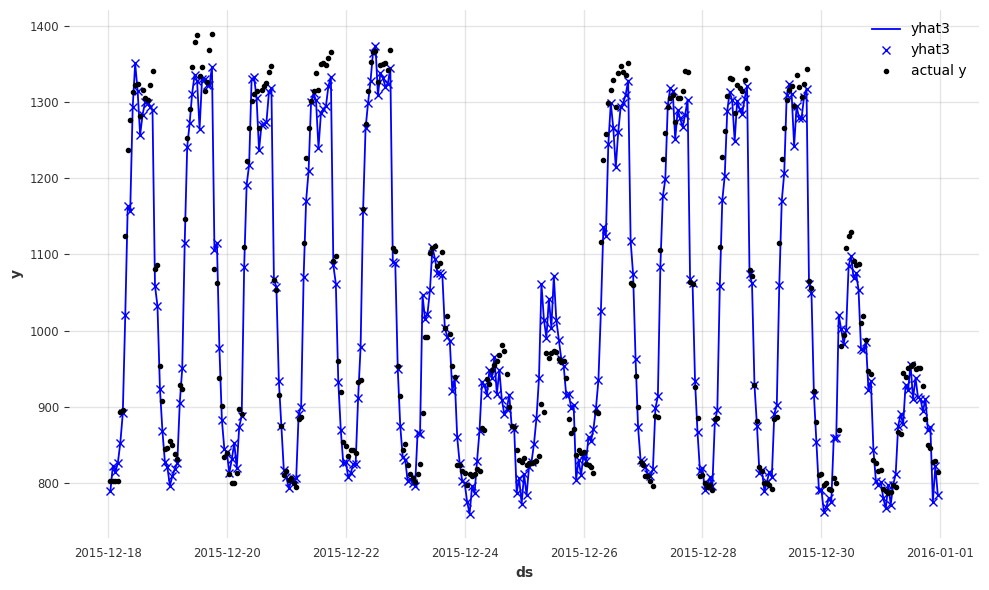

In [90]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    n_lags=24,
    num_hidden_layers=1,
    d_hidden=64,
    epochs=EPOCHS,
    n_changepoints=0, 
    growth='linear',
)
metrics_train = m.fit(df=df_train_sf_load, freq="H",minimal=True)
forecast = m.predict(df=df_test_sf_load)
MAPE, test_metrics_list= calc_MAPE(forecast, df_test_sf_load)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)

m.plot(forecast, plotting_backend='plotly', forecast_in_focus=N_FORECASTS)

**Result discussion**: Comparing all models, the **NeuralProphet configuration 3** achieves the best results on the SFLoad data. The **NeuralProphet configuration 2** shows a performance close to that. Hence, we can conclude that autoregression is essential to perform well on predicting the future data. Adding a hidden layer to the model benefits the performance further. The individual shapes of the data can be predicted better in this case. 
Models without autoregressive capabilities perform comparatively worse. Except the performance of the **LinearRegression** is close to the models with autoregressive capabilities.


## 4. Set up simple benchmark 3 with Energy data and the same 6 models
##### Configure and run the benchmark

We select the Energy dataset, select and configure the models, and set up the benchmark by using the SimpleBenchmark template the same way as before. 

In [59]:
dataset_list = [
    Dataset(df=df_energy, name="energy", freq="H"),
]

In [60]:
N_FORECASTS = 3
LR = 0.01
EPOCHS = 20

In [61]:
model_classes_and_params = [
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 36,
                          "daily_seasonality": True, "num_hidden_layers": 2, "d_hidden": 64,
                          "n_changepoints":4, "changepoints_range":1,
                          "learning_rate": LR, "epochs": EPOCHS }),
    (NeuralProphetModel, {"n_forecasts": N_FORECASTS, "n_lags": 36,
                          "daily_seasonality": True,
                          "n_changepoints":4, "changepoints_range":1,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (NeuralProphetModel, {"n_forecasts": 1,
                          "daily_seasonality": True,
                          "n_changepoints":4, "changepoints_range":1,
                          "learning_rate": LR, "epochs": EPOCHS}),
    (ProphetModel, {"daily_seasonality": True}),
    (TorchProphetModel, {'interval_width': 0, "daily_seasonality": True, "learning_rate": LR, "epochs": EPOCHS}),
    (SeasonalNaiveModel, {"n_forecasts": N_FORECASTS, "season_length": 24}),
    (NaiveModel, {"n_forecasts": N_FORECASTS}),
    (LinearRegressionModel, {"n_forecasts": N_FORECASTS, "lags": 24, "output_chunk_length": 3}),
]

In [62]:
benchmark = SimpleBenchmark(
    model_classes_and_params=model_classes_and_params,
    datasets=dataset_list,
    metrics=["MAPE"],
    test_percentage=40,
)

We run the benchmark by calling benchmark.run() and print the train and test results.

In [63]:
results_train, results_test = benchmark.run()
results_test

08:37:01 - cmdstanpy - INFO - Chain [1] start processing
08:37:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/21013 [00:00<?, ?it/s]

  0%|          | 0/13999 [00:00<?, ?it/s]

,data,model,params,experiment,MAPE
0,energy,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 36, 'daily_season...",energy_NeuralProphet_n_forecasts_3_n_lags_36_d...,5.520187
1,energy,NeuralProphet,"{'n_forecasts': 3, 'n_lags': 36, 'daily_season...",energy_NeuralProphet_n_forecasts_3_n_lags_36_d...,5.660652
2,energy,NeuralProphet,"{'n_forecasts': 1, 'daily_seasonality': True, ...",energy_NeuralProphet_n_forecasts_1_daily_seaso...,14.962934
3,energy,Prophet,"{'daily_seasonality': True, '_data_params': {'...",energy_Prophet_daily_seasonality_True__data_pa...,68.396317
4,energy,TorchProphet,"{'interval_width': 0, 'daily_seasonality': Tru...",energy_TorchProphet_interval_width_0_daily_sea...,15.997113
5,energy,SeasonalNaive,"{'n_forecasts': 3, 'season_length': 24, '_data...",energy_SeasonalNaive_n_forecasts_3_season_leng...,9.373035
6,energy,NaiveModel,"{'n_forecasts': 3, '_data_params': {'freq': 'H'}}",energy_NaiveModel_n_forecasts_3__data_params_{...,6.957590
7,energy,LinearRegressionModel,"{'n_forecasts': 3, 'lags': 24, 'output_chunk_l...",energy_LinearRegressionModel_n_forecasts_3_lag...,4.538339


## Let`s have a look at the individual results
We manually split the train and test data.


In [64]:
df_train_energy, df_test_energy = split_df(df=df_energy, n_lags=36, test_percentage=0.40, local_split=False)
df_train_energy_1step, df_test_energy_1step = split_df(df=df_energy, n_lags=0, test_percentage=0.40, local_split=False)

#### NeuralProphet Configuration 1
The Energy data has a daily seasonality. We can observe a changing trend, that why we adjust the number of changepoints to  ``n_changepoints=4`` and set full changepoint range ``changepoints_range=1 ``.

Training: 0it [00:00, ?it/s]

Predicting: 329it [00:00, ?it/s]

MAPE for each forecast step [1.885266974568367, 2.022111974656582, 2.47490331530571]
MAPE 14.963719


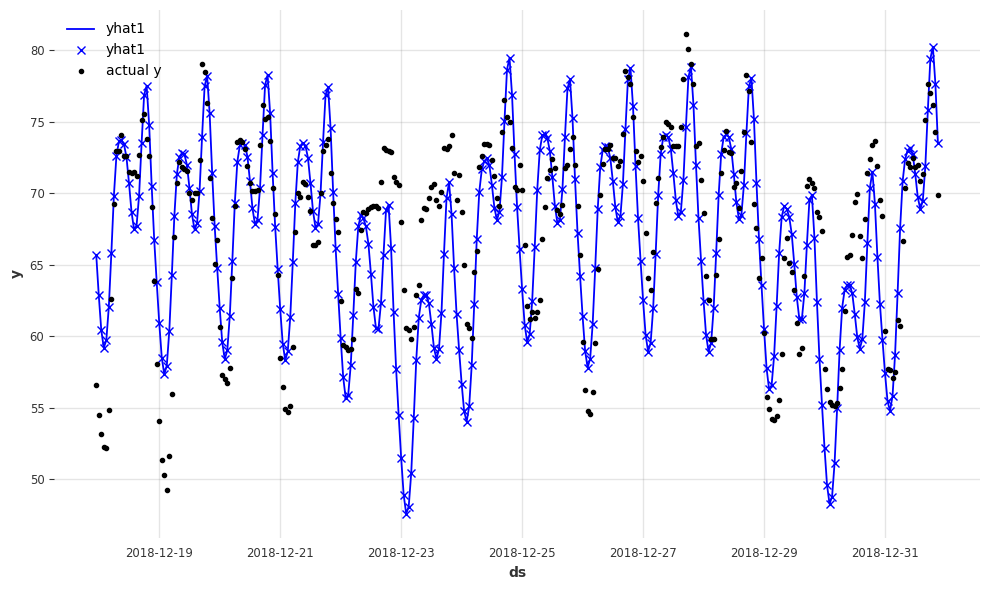

In [91]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=1,
    daily_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
    n_changepoints=4,
    changepoints_range=1,
)
metrics_train = m.fit(df=df_train_energy_1step, freq="H")
forecast = m.predict(df=df_test_energy_1step)
MAPE, metric_test_list = calc_MAPE(forecast, df_test_energy_1step)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=1)

#### NeuralProphet Configuration 2

We add autoregression to the model selecting ``n_lags=36``. 

Training: 0it [00:00, ?it/s]

Predicting: 329it [00:00, ?it/s]

MAPE for each forecast step [1.885266974568367, 2.022111974656582, 2.47490331530571]
MAPE 5.660652


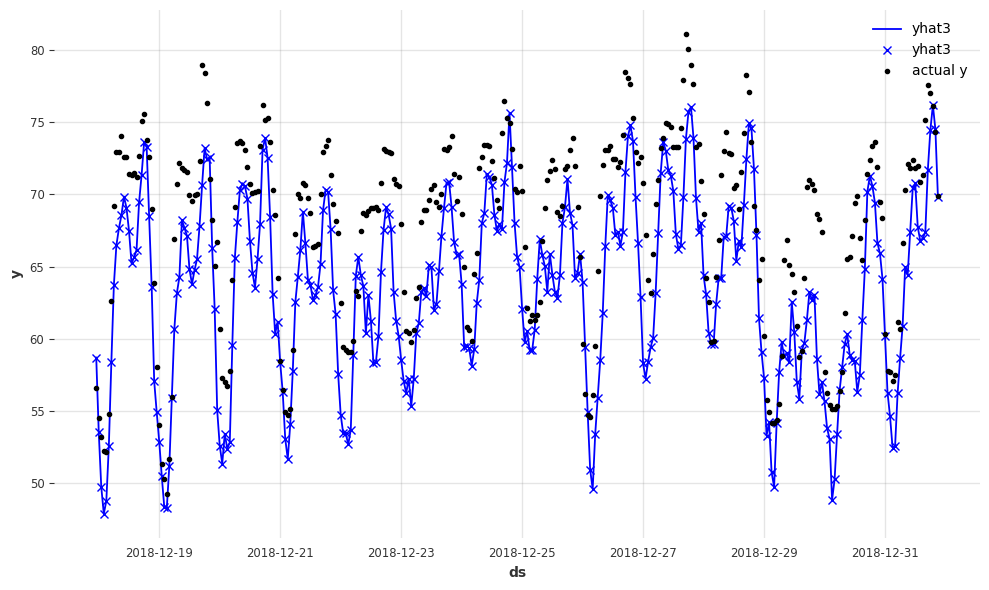

In [92]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags=36,
    daily_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
    n_changepoints=4,
    changepoints_range=1,
)
metrics_train = m.fit(df=df_train_energy, freq="H")
forecast = m.predict(df=df_test_energy)
MAPE, metric_test_list = calc_MAPE(forecast, df_test_energy)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=N_FORECASTS)

#### NeuralProphet Configuration 3

We add two hidden layer ``num_hidden_layers=2`` with ``d_hidden=64``.

Training: 0it [00:00, ?it/s]

Predicting: 329it [00:00, ?it/s]

MAPE for each forecast step [1.885266974568367, 2.022111974656582, 2.47490331530571]
MAPE 5.520187


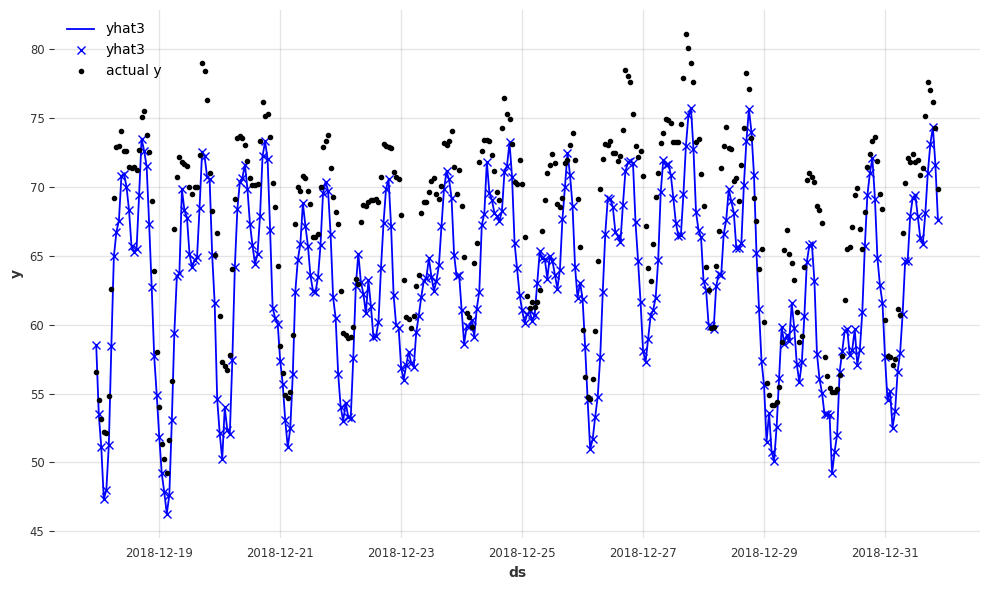

In [93]:
set_random_seed(42)
m = NeuralProphetModel.model_class(
    n_forecasts=N_FORECASTS,
    n_lags=36,
    daily_seasonality=True,
    learning_rate=LR,
    epochs=EPOCHS,
    n_changepoints=4,
    changepoints_range=1,
    num_hidden_layers=2,
    d_hidden=64,
)
metrics_train = m.fit(df=df_train_energy, freq="H")
forecast = m.predict(df=df_test_energy)
MAPE, metric_test_list = calc_MAPE(forecast, df_test_energy)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=1)

#### TorchProphet 

MAPE for each forecast step [1.885266974568367, 2.022111974656582, 2.47490331530571]
MAPE 15.998141


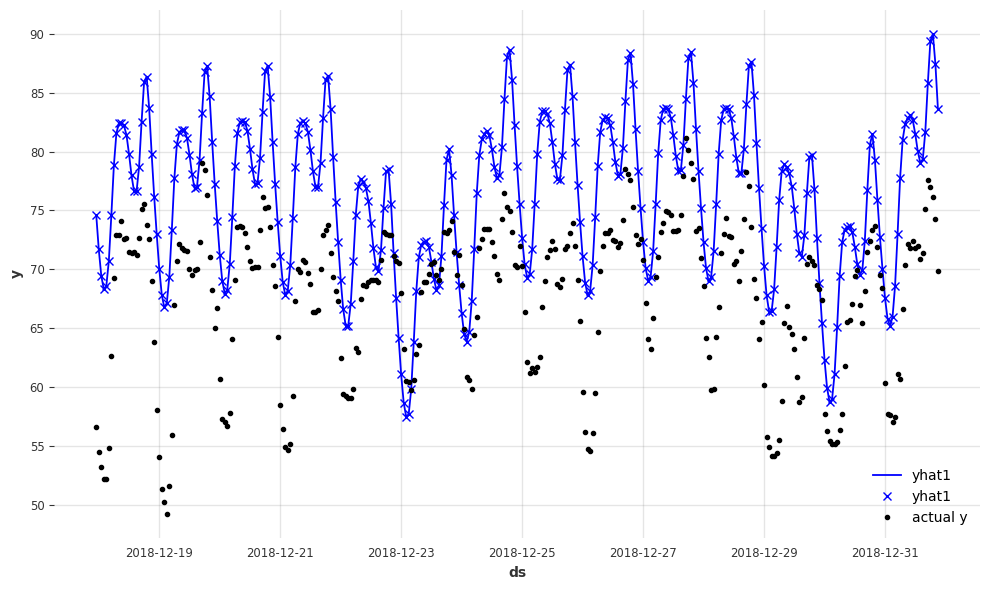

In [99]:
set_random_seed(42)
m = TorchProphetModel.model_class(
    interval_width=0,
    learning_rate=LR,
    epochs=EPOCHS,
)
metrics_train  = m.fit(df=df_train_energy_1step, freq="H", minimal=True)
forecast  = m.predict(df=df_test_energy_1step)
MAPE , test_metric_list  = calc_MAPE(forecast, df_test_energy_1step)
print('MAPE for each forecast step', test_metrics_list)
print('MAPE', MAPE)
m.plot(forecast, plotting_backend='plotly', forecast_in_focus=1)

**Result discussion**: Comparing all models, the **NeuralProphet configuration 3** achieves the best results on the Energy data. However, the performace of Neuralprophet in all its configurations is generally not as good as for the SFLoad data. One reason might be the high amount of spikes in the data. A way to achieve a better performance on such data would be to add regressors to the NueralPropeht model. 